In [260]:
import json
result_data = json.load(open('./results/sgcls/test_predict.json'))


In [261]:
index = 610
display(result_data[index])
display(result_data[index]['hyp'][0])
display(result_data[index]['img_id'])

{'img_id': '2342967',
 'hyp': [['zebra', 'has', 'tail'],
  ['zebra', 'has', 'leg'],
  ['zebra', 'has', 'head'],
  ['zebra', 'has', 'leg'],
  ['tree', 'has', 'trunk'],
  ['tree', 'behind', 'zebra']],
 'ref': [['man', 'wearing', 'shoe'],
  ['man', 'wearing', 'sock'],
  ['man', 'wearing', 'shirt'],
  ['man', 'wearing', 'sock'],
  ['window', 'on', 'building'],
  ['shirt', 'on', 'man']],
 'pred_count': {'and': [0, 0],
  'says': [0, 0],
  'belonging to': [0, 0],
  'over': [0, 0],
  'parked on': [0, 0],
  'growing on': [0, 0],
  'standing on': [0, 0],
  'made of': [0, 0],
  'attached to': [0, 0],
  'at': [0, 0],
  'in': [0, 0],
  'hanging from': [0, 0],
  'wears': [0, 0],
  'in front of': [0, 0],
  'from': [0, 0],
  'for': [0, 0],
  'watching': [0, 0],
  'lying on': [0, 0],
  'to': [0, 0],
  'behind': [0, 0],
  'flying in': [0, 0],
  'looking at': [0, 0],
  'on back of': [0, 0],
  'holding': [0, 0],
  'between': [0, 0],
  'laying on': [0, 0],
  'riding': [0, 0],
  'has': [0, 0],
  'across': [

['zebra', 'has', 'tail']

'2342967'

In [262]:

import json
import requests
from io import BytesIO
import h5py
from PIL import Image

img_data_dict = json.load(open('/data/hulab/zcai75/visual_genome/vg_motif_anno/image_data.json'))
idx_by_id = {img_data['image_id']: i for i, img_data in enumerate(img_data_dict)}
j=idx_by_id[int(result_data[index]['img_id'])]
img_data = img_data_dict[j]
raw = requests.get(img_data['url']).content
image = Image.open(BytesIO(raw))

ann = h5py.File('/data/hulab/zcai75/visual_genome/vg_motif_anno/VG-SGG-with-attri.h5', 'r')
label_data = json.load(open('/data/hulab/zcai75/visual_genome/vg_motif_anno/VG-SGG-dicts-with-attri.json'))
first_rel = ann['img_to_first_rel'][j]
last_rel = ann['img_to_last_rel'][j]
img_rels = ann['relationships'][first_rel : last_rel+1]
box1_ids = [ann['labels'][i][0] for i in img_rels[:, 0]]
box2_ids = [ann['labels'][i][0] for i in img_rels[:, 1]]
pred_ids = ann['predicates'][first_rel : last_rel+1]
pred_label = [label_data['idx_to_predicate'][str(i[0])].encode('utf-8') for i in pred_ids]
box1_label = [label_data['idx_to_label'][str(i)].encode('utf-8') for i in box1_ids]
box2_label = [label_data['idx_to_label'][str(i)].encode('utf-8') for i in box2_ids]
max_image_size = max(image.size)
display(list(zip(box1_label, pred_label, box2_label)))


[(b'man', b'wearing', b'shoe'),
 (b'man', b'wearing', b'shoe'),
 (b'man', b'wearing', b'shoe'),
 (b'man', b'wearing', b'shoe'),
 (b'man', b'wearing', b'sock'),
 (b'man', b'wearing', b'sock'),
 (b'man', b'wearing', b'sock'),
 (b'man', b'wearing', b'sock'),
 (b'man', b'wearing', b'shirt'),
 (b'man', b'wearing', b'shirt'),
 (b'window', b'on', b'building'),
 (b'shirt', b'of', b'man'),
 (b'shirt', b'of', b'man'),
 (b'shirt', b'of', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man')]

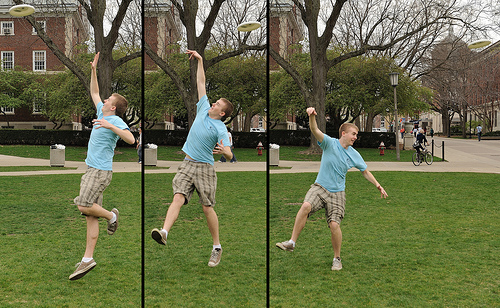

In [263]:
display(image)

In [264]:
import torch
import numpy as np
from fairseq import utils, tasks, options
from fairseq import checkpoint_utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from utils.eval_utils import eval_step
from tasks.mm_tasks.caption import CaptionTask
from models.ofa import OFAModel
from PIL import Image

# Register refcoco task
tasks.register_task('caption', CaptionTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

# specify some options for evaluation
parser = options.get_generation_parser()
input_args = ["", "--task=sgcls", "--beam=5", "--path=/data/hulab/zcai75/checkpoints/OFA/sgcls_checkpoints/_20_3e-5_512/tmp/checkpoint_last.pt", "--bpe-dir=utils/BPE"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)

In [265]:
task = tasks.setup_task(cfg.task)

# Load pretrained ckpt & config
overrides={"eval_cider":False, "beam":5, "max_len_b":1000, "no_repeat_ngram_size":6, "seed":7, "diversity_rate": 0.0, "min_len": 80}
# "diverse_beam_groups": 8, "diverse_beam_strength": 0.8
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths(cfg.common_eval.path),
        arg_overrides=overrides,
        task=task
    )

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

In [266]:
# Image transform
from torchvision import transforms
from data import data_utils
import random
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose(
    [
        lambda image: image.convert("RGB"),
        transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False, use_bpe=True):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text) if use_bpe else text,
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s
def coord2bin(coord_list, box_size, num_bins):
	bin_list = []
	bin_list += ["<bin_{}>".format(int(round(coord_list[0] / box_size * (num_bins - 1))))]
	bin_list += ["<bin_{}>".format(int(round(coord_list[1] / box_size * (num_bins - 1))))]
	bin_list += ["<bin_{}>".format(int(round(coord_list[2] / box_size * (num_bins - 1))))]
	bin_list += ["<bin_{}>".format(int(round(coord_list[3] / box_size * (num_bins - 1))))]
	return ' '.join(bin_list)
def collate(samples, pad_idx, eos_idx):
    if len(samples) == 0:
        return {}

    def merge(key):
        return data_utils.collate_tokens(
            [s[key] for s in samples],
            pad_idx,
            eos_idx=eos_idx,
        )

    id = np.array([s["id"] for s in samples])
    src_tokens = merge("source")
    src_lengths = torch.LongTensor([s["source"].ne(pad_idx).long().sum() for s in samples])

    patch_images = torch.stack([sample['patch_image'] for sample in samples], dim=0)
    patch_masks = torch.cat([sample['patch_mask'] for sample in samples])

    prev_output_tokens = None
    target = None
    if samples[0].get("target", None) is not None:
        target = merge("target")
        tgt_lengths = torch.LongTensor([s["target"].ne(pad_idx).long().sum() for s in samples])
        ntokens = tgt_lengths.sum().item()

        if samples[0].get("prev_output_tokens", None) is not None:
            prev_output_tokens = merge("prev_output_tokens")
    else:
        ntokens = src_lengths.sum().item()

    batch = {
        "id": id,
        "nsentences": len(samples),
        "ntokens": ntokens,
        "net_input": {
            "src_tokens": src_tokens,
            "src_lengths": src_lengths,
            "patch_images": patch_images,
            "patch_masks": patch_masks,
            "prev_output_tokens": prev_output_tokens
        },
        "target": target,
    }

    return batch

# Construct input for caption task
def construct_sample(index, f, d):
    img_data_dict = json.load(open('/data/hulab/zcai75/visual_genome/vg_motif_anno/image_data.json'))
    idx_by_id = {img_data['image_id']: i for i, img_data in enumerate(img_data_dict)}
    j=idx_by_id[int(result_data[index]['img_id'])]
    img_data = img_data_dict[j]
    raw = requests.get(img_data['url']).content
    image = Image.open(BytesIO(raw))
    first_rel, last_rel, first_box, last_box, split = f['img_to_first_rel'][j], f['img_to_last_rel'][j], f['img_to_first_box'][j], f['img_to_last_box'][j], f['split'][j]

    pred_ids = f['predicates'][first_rel : last_rel+1].squeeze().tolist()
    boxes = f['boxes_1024'][first_box : last_box+1].squeeze().tolist()
    box_ids = f['labels'][first_box : last_box+1].squeeze().tolist()
    pred_label = [d['idx_to_predicate'][str(i)] for i in pred_ids]
    box_label = [d['idx_to_label'][str(i)] for i in box_ids]
    box_range = [first_box, last_box]

    patch_image = patch_resize_transform(image)
    patch_mask = torch.tensor([True])

    dic = {}
    lower = box_range[0]
    # print(self.dataset[index][:-1])
    for i, rel in enumerate(img_rels):
        rel = rel
        pred = task.bpe.encode(' {}'.format(pred_label[i]))
        if rel[0] not in dic:
            dic[rel[0]] = {rel[1]: pred}
        else:
            dic[rel[0]][rel[1]] = pred
    
    caption = ""
    for r1 in dic:
        l1 = task.bpe.encode(' {}'.format(box_label[int(r1) - lower]))
        caption += "<sub> {} ".format(l1)
        for r2 in dic[r1]:
            l2 = task.bpe.encode(' {}'.format(box_label[int(r2) - lower]))
            caption += "<pred> {} <obj> {} ".format(dic[r1][r2], l2)

    # print(caption)

    caption_token_list = caption.strip().split()
    tgt_caption = ' '.join(caption_token_list[:1000])

    # w_resize_ratio = self.patch_image_size / image.width
    # h_resize_ratio = self.patch_image_size / image.height
    # boxes = [task.bpe.encode(' {}'.format(box_label[i])) + coord2bin(list(map(int, box)), 1024, 1000) for i, box in enumerate(boxes)]
    boxes = [coord2bin(list(map(int, box)), 1024, 1000) for i, box in enumerate(random.sample(boxes, len(boxes)))]
    # boxes = [coord2bin(list(map(int, box)), 1024, 1000) for i, box in enumerate(boxes)]
    boxes_str = ' , '.join(boxes)
    
    src_item = encode_text(boxes_str, use_bpe=False)
    tgt_item = encode_text(tgt_caption, use_bpe=False)

    src_item = torch.cat([bos_item, src_item, eos_item])
    target_item = torch.cat([tgt_item, eos_item])
    prev_output_item = torch.cat([bos_item, tgt_item])
    # print(len(src_item), len(target_item), len(prev_output_item))

    example = {
        "id": index,
        "source": src_item,
        "patch_image": patch_image,
        "patch_mask": patch_mask,
        "target": target_item,
        "prev_output_tokens": prev_output_item
    }
    return collate([example], pad_idx, task.src_dict.eos())
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/tmp/ipykernel_1651631/2616290083.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),


In [267]:
# Construct input sample & preprocess for GPU if cuda available
import random
from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode

sample = construct_sample(index, ann, label_data)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

In [268]:
import string
def decode(toks):
    s = task.tgt_dict.string(toks.int().cpu())
    return s

def decode_fn(x, tgt_dict, bpe, generator, tokenizer=None):
    x = tgt_dict.string(x.int().cpu(), extra_symbols_to_ignore=get_symbols_to_strip_from_output(generator))
    if bpe is not None:
        x = bpe.decode(x)
    if tokenizer is not None:
        x = tokenizer.decode(x)
    return x

def get_symbols_to_strip_from_output(generator):
    if hasattr(generator, "symbols_to_strip_from_output"):
        return generator.symbols_to_strip_from_output
    else:
        return {generator.bos, generator.eos}

def eval_caption(task, generator, models, sample, **kwargs):
    # transtab = str.maketrans({key: None for key in string.punctuation})
    hypos = task.inference_step(generator, models, sample)
    results = []
    for i, sample_id in enumerate(sample["id"].tolist()):
        detok_hypo_str = [decode_fn(hypos[i][j]["tokens"], task.tgt_dict, task.bpe, generator) for j in range(len(hypos[i]))]
        results.append({"image_id": str(sample_id), "tokens": [decode(hypos[i][j]["tokens"]) for j in range(len(detok_hypo_str))], "captions": [detok_hypo_str[j].strip() for j in range(len(detok_hypo_str))]})
    return results, None

In [269]:
# Run eval step for caption
with torch.no_grad():
    result, scores = eval_caption(task, generator, models, sample)

In [270]:
def toks2triplets(toks, task):
    triplets = []
    curr_sub = ''
    curr_obj = ''
    curr_pred = ''
    state = None
    toks.append('<sub>')
    for i, tok in enumerate(toks):
        # print(tok, '|'.join([curr_sub, curr_obj, curr_pred]), triplets)
        if tok == '<sub>':
            state = 'sub'
            curr_sub = ''
            if len(curr_obj) > 0 and len(triplets[-1]) == 2:
                triplets[-1].append(task.bpe.decode(curr_obj).strip())

        elif tok == '<pred>':
            state = 'pred'
            if len(curr_obj) > 0 and len(triplets[-1]) == 2: 
                triplets[-1].append(task.bpe.decode(curr_obj).strip())
            triplets.append([task.bpe.decode(curr_sub).strip()])
            curr_pred = ''
        elif tok == '<obj>':
            state = 'obj'
            triplets[-1].append(task.bpe.decode(curr_pred).strip())
            curr_obj = ''
            
        else:
            if state == 'sub':
                curr_sub += ' ' + tok
            elif state == 'obj':
                curr_obj += ' ' + tok
            elif state == 'pred':
                curr_pred += ' ' + tok

    if len(triplets[-1]) < 3:
        del triplets[-1]
    for trip in triplets:
        if len(trip) > 3:
            print(trip)
            trip = trip[:3]
    return triplets

display(result[0]['captions'])
display(toks2triplets(result[0]['tokens'][0].split(), task))
display(list(zip(box1_label, pred_label, box2_label)))

['<sub> leaf<pred> on<obj> tree<pred> on<obj> tree<sub> leaf<pred> on<obj> branch<sub> leaf<pred> on<obj> plant<sub> leaf<pred> on<obj> sidewalk<sub> leaf<pred> on<obj> street<sub> pole<pred> holding<obj> sign<sub> sign<pred> on<obj> pole<pred> on<obj> pole<sub> pole<pred> with<obj> sign<sub> tree<pred> with<obj> leaf<pred> with<obj> leaf<sub> leaf<pred> of<obj> plant<sub> leaf<pred> of<obj> tree<sub> plant<pred> with<obj> leaf',
 '<sub> leaf<pred> on<obj> tree<pred> on<obj> tree<sub> leaf<pred> on<obj> branch<sub> leaf<pred> on<obj> plant<sub> leaf<pred> on<obj> sidewalk<sub> leaf<pred> on<obj> street<sub> pole<pred> holding<obj> sign<sub> sign<pred> on<obj> pole<pred> on<obj> pole<sub> pole<pred> with<obj> sign<sub> tree<pred> with<obj> leaf<pred> with<obj> leaf<sub> leaf<pred> of<obj> plant<sub> leaf<pred> of<obj> tree<sub> pole<pred> of<obj> sign',
 '<sub> leaf<pred> on<obj> tree<pred> on<obj> tree<sub> leaf<pred> on<obj> branch<sub> leaf<pred> on<obj> plant<sub> leaf<pred> on<obj>

[['leaf', 'on', 'tree'],
 ['leaf', 'on', 'tree'],
 ['leaf', 'on', 'branch'],
 ['leaf', 'on', 'plant'],
 ['leaf', 'on', 'sidewalk'],
 ['leaf', 'on', 'street'],
 ['pole', 'holding', 'sign'],
 ['sign', 'on', 'pole'],
 ['sign', 'on', 'pole'],
 ['pole', 'with', 'sign'],
 ['tree', 'with', 'leaf'],
 ['tree', 'with', 'leaf'],
 ['leaf', 'of', 'plant'],
 ['leaf', 'of', 'tree'],
 ['plant', 'with', 'leaf']]

[(b'man', b'wearing', b'shoe'),
 (b'man', b'wearing', b'shoe'),
 (b'man', b'wearing', b'shoe'),
 (b'man', b'wearing', b'shoe'),
 (b'man', b'wearing', b'sock'),
 (b'man', b'wearing', b'sock'),
 (b'man', b'wearing', b'sock'),
 (b'man', b'wearing', b'sock'),
 (b'man', b'wearing', b'shirt'),
 (b'man', b'wearing', b'shirt'),
 (b'window', b'on', b'building'),
 (b'shirt', b'of', b'man'),
 (b'shirt', b'of', b'man'),
 (b'shirt', b'of', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man'),
 (b'shirt', b'on', b'man')]

In [271]:
display(decode_fn(sample['net_input']['src_tokens'][0], task.src_dict, task.bpe, generator))

'<bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0><unk><bin_0><bin_0><bin_0><bin_0>'

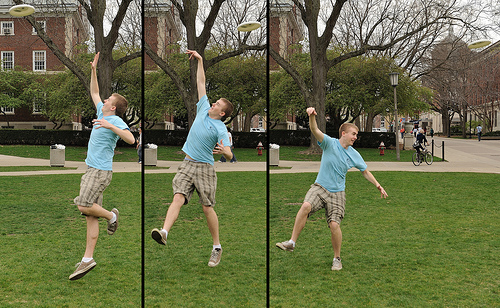

In [157]:
display(image)